In [1]:
import matplotlib.pyplot as plt
import numpy as np
from lowEBMs.Packages.Configuration import importer, add_sellersparameters, parameterinterpolatorstepwise, reset
from lowEBMs.Packages.Configuration import import_parallelparameter, allocate_parallelparameter, write_parallelparameter
from lowEBMs.Packages.Variables import variable_importer
from lowEBMs.Packages.RK4 import rk4alg
from lowEBMs.Packages.ModelEquation import model_equation
from lowEBMs.Packages.Variables import Vars,reset, trackerreset, datareset
from lowEBMs.Packages.Functions import plotmeanstd
from lowEBMs import update_plotstyle, moving_average
import lowEBMs.Packages.Constants as const

import builtins
import matplotlib
update_plotstyle()
matplotlib.rcParams['lines.linewidth']=1.1

In [2]:
Lat_10,ZMT_10=np.loadtxt('Data/ERA_ZMT_Mean_10deginterpolated.txt')
Lat_ERA,ZMT_ERA=np.loadtxt('Data/ERA_ZMT_Mean.txt')


In [3]:
def coremodule(config,P0,P_pert_ratio,Pmin,Pmax,labels,ZMT,GMT,grid,maxlength,targetmode,target,targetfunction,ratio_ZMT_GMT,elevation,precision,num_paras,gamma0,control,controlconfig):
    from tqdm import tqdm, tnrange
    
    F=np.reshape(np.zeros(maxlength*(2*num_paras+1)),(maxlength,2*num_paras+1))
    dF=np.reshape(np.zeros(maxlength*(num_paras)),(maxlength,num_paras))
    P=np.reshape(np.zeros(maxlength*(num_paras)),(maxlength,num_paras))
    Ptrans=np.reshape(np.zeros(maxlength*(num_paras)),(maxlength,num_paras))
    gamma=np.zeros(maxlength)
    
    if targetmode=='Single':
        dataout=np.reshape(np.zeros(maxlength*(2*num_paras+1)),(maxlength,(2*num_paras+1)))
    elif targetmode=='ZMT':
        dataout=np.reshape(np.zeros(maxlength*len(grid)*(2*num_paras+1)),(maxlength,(2*num_paras+1),len(grid)))
    elif targetmode=='GMT':
        dataout=np.reshape(np.zeros(maxlength*int(number_of_integration/data_readout)*(2*num_paras+1)),(maxlength,(2*num_paras+1),int(number_of_integration/data_readout)))
    elif targetmode=='Coupled':
        dataout_ZMT=np.reshape(np.zeros(maxlength*len(grid)*(2*num_paras+1)),(maxlength,(2*num_paras+1),len(grid)))
        dataout_GMT=np.reshape(np.zeros(maxlength*int(number_of_integration/data_readout)*(2*num_paras+1)),(maxlength,(2*num_paras+1),int(number_of_integration/data_readout)))     
    for i in tnrange(maxlength):
        print('Iteration no.'+str(i))
        if i==0:
            P[i]=P0
            P_pert=(Pmax-Pmin)*P_pert_ratio
            Ptrans[i]=(P0-Pmin)/(Pmax-Pmin)
            Ptrans_pert=Ptrans[i]*P_pert_ratio

        if targetmode=='Coupled':
            data_ZMT,data_GMT=run_model(config,P[i],P_pert,labels,ZMT,GMT,targetmode,control,controlconfig,grid,elevation)
            dataout_ZMT[i]=data_ZMT
            dataout_GMT[i]=data_GMT
        else:
            data=run_model(config,P[i],P_pert,labels,ZMT,GMT,targetmode,control,controlconfig,grid,elevation)
            dataout[i]=data
            
        if targetmode=='Coupled':
            target_ZMT=target['ZMT']
            target_GMT=target['GMT']
            F_ZMT=target_comparison(data_ZMT,'ZMT',target_ZMT,targetfunction,num_paras,grid)
            F_GMT=target_comparison(data_GMT,'GMT',target_GMT,targetfunction,num_paras,grid)
            F[i]=ratio_ZMT_GMT*F_ZMT+(1-ratio_ZMT_GMT)*F_GMT
        else:
            F[i]=target_comparison(data,targetmode,target,targetfunction,num_paras,grid)

        dF[i]=local_gradient(F[i],Ptrans_pert)
        #dF[i]=local_gradient(F[i],P_pert)
        if i==0:
            gamma[i]=gamma0
        else:
            #gamma[i]=step_weighting(dF[i-1],dF[i],P[i-1],P[i])
            gamma[i]=step_weighting(dF[i-1],dF[i],Ptrans[i-1],Ptrans[i])
            
        if precision_check(dF[0],dF[i],precision):
            print('stop',i)
            P=P[:i]
            Ptrans=Ptrans[:i]
            F=F[:i]
            dF=dF[:i]
            gamma=gamma[:i]
            break
                
        #P_next=new_parameters(P[i],gamma[i],dF[i])        
        Ptrans_next=new_parameters(Ptrans[i],gamma[i],dF[i])

        for k in range(num_paras):
            if Ptrans_next[k]<0:
                Ptrans_next[k]=0.
            if Ptrans_next[k]>1:
                Ptrans_next[k]=1.

        if i<maxlength-1:
            Ptrans[i+1]=Ptrans_next
            P[i+1]=Pmin+Ptrans_next*(Pmax-Pmin)
            print(F[i])
            print(gamma[i])
            print(P[i+1])
            
        if targetmode=='Coupled':
            dataout=[dataout_ZMT,dataout_GMT]
            
    return F, dF, P , Ptrans, gamma, dataout
    
def target_comparison(data,targetmode,target,targetfunction,num_paras,grid):
    F=np.zeros(2*num_paras+1)
    if targetfunction=='LeastSquare':
        if targetmode=='Single':
            F=(np.array(data)-target)**2
        elif targetmode=='ZMT':
            for i in range(len(F)):
                if len(data[i])==len(target):
                    F[i]=np.sum(((data[i]-target)*np.cos(grid*np.pi/180)/np.mean(np.cos(grid*np.pi/180)))**2)
                elif len(data[i])==len(F):
                    F[i]=np.sum(((data[:,i]-target)*np.cos(grid*np.pi/180)/np.mean(np.cos(grid*np.pi/180)))**2)
        elif targetmode=='GMT':
            for i in range(len(F)):
                F[i]=np.sum((data[i]-target)**2)

    return F

def local_gradient(F,P_pert):
    dF=np.zeros(len(P_pert))
    for k in range(len(P_pert)):
        dF[k]=(F[2*(k+1)-1]-F[2*(k+1)])/(2*P_pert[k])
    return dF

def step_weighting(dF0,dF1,P0,P1):
    gamma=np.abs(np.dot(P1-P0,dF1-dF0)/np.dot(np.abs(dF1-dF0),np.abs(dF1-dF0)))
    return gamma

def precision_check(dF0,dF,precision):
    dFabs=np.sqrt(np.dot(dF,dF))
    dF0abs=np.sqrt(np.dot(dF0,dF0))
    if dFabs/dF0abs <= precision:
        return True
    
def new_parameters(P,gamma,dF):
    P_next=P-gamma*dF
    return P_next

def run_model(config,P,P_pert,labels,ZMT,GMT,targetmode,control,controlconfig,grid,elevation):
    
    P_config=reshape_parameters(P,P_pert)
    setup={'number_of_parameters': len(P), 'number_of_cycles': 1, 'number_of_parallels': len(P)*2+1}
    
    if targetmode=='Coupled':
        control=True
        
    if control==True:
        variable_importer(controlconfig,initialZMT=True,parallel=True,parallel_config=setup)
        controlconfig=add_parameters(controlconfig,P_config,labels)
        data_CTRL=rk4alg(model_equation,controlconfig['eqparam'],controlconfig['rk4input'],controlconfig['funccomp'],progressbar=True)
        ZMT,GMT=data_CTRL[1][-1],data_CTRL[2][-1]

    variable_importer(config,initialZMT=False,parallel=True,parallel_config=setup)
    config=add_parameters(config,P_config,labels)
    Vars.T,Vars.T_global=ZMT,GMT   
    data=rk4alg(model_equation,config['eqparam'],config['rk4input'],config['funccomp'],progressbar=True)
    
    if targetmode=='Single':
        data_out=data[2][-1]
    elif targetmode=='ZMT':
        dataZMT=data[1][-1]
        for i in range(len(dataZMT)):
            dataZMT[i]=dataZMT[i]+elevation
        data_out=dataZMT
    elif targetmode=='GMT':
        data_out=np.transpose(data[2][:-1]-data[2][0])
    elif targetmode=='Coupled':
        dataZMT=data_CTRL[1][-1]
        for i in range(len(dataZMT)):
            dataZMT[i]=dataZMT[i]+elevation
        dataGMT=np.transpose(data[2][:-1]-data[2][0])
        data_out=[dataZMT,dataGMT]
    return data_out

def reshape_parameters(P,P_pert):
    num_para=len(P)
    P_config=np.reshape(np.zeros(num_para*(2*num_para+1)),(num_para,2*num_para+1))
    for i in range(num_para):
        P_config[i]=np.array([P[i]]*(2*num_para+1))
        P_config[i][i*2+1]=P[i]+P_pert[i]
        P_config[i][i*2+2]=P[i]-P_pert[i]
                      
    return P_config
             
def add_parameters(config,P_config,labels):
    num_para=len(P_config)
    
    for i in range(num_para):
        if labels[i][0][:4]=='func':
            config['funccomp']['funcparam'][labels[i][0]][labels[i][1]]=P_config[i]
        if labels[i][0]=='eqparam':
            config[labels[i][0]][labels[i][1]]=P_config[i]
    return config

In [ ]:
#labels=[['eqparam','c_ao'],['func1','a'],['func1','b'],['func2','factor_oc'],['func2','factor_kwv'],['func2','factor_kair']]
labels=[['func1','m'],['func1','gamma'],['func2','factor_oc'],['func2','factor_kwv'],['func2','factor_kair']]
#labels=[['func1','a'],['func1','b']]
P0=np.array([0.5,1.9e-15,1.165,1.165,1.165])
Pmin=np.array([0.4,0.5e-15,0.9,0.9,0.9])
Pmax=np.array([0.6,5e-15,1.3,1.3,1.3])

"""labels=[['eqparam','c_ao'],['func1','a'],['func1','b'],['func2','factor_oc'],['func2','factor_kwv'],['func2','factor_kair']]
P0=np.array([70*4.2e6,230,2.5,1.165,1.165,1.165])
Pmin=np.array([1*4.2e6,190,1.9,0.9,0.9,0.9])
Pmax=np.array([150*4.2e6,250,3.3,1.3,1.3,1.3])"""

#labels=[['func3','f1'],['func3','f2'],['func3','f3'],['func3','f4'],['func3','f5'],['func3','f6'],['func3','f7'],['func3','f8'],['func3','f9'],['func3','f10'],\
#       ['func3','f11'],['func3','f12'],['func3','f13'],['func3','f14'],['func3','f15'],['func3','f16'],['func3','f17'],['func3','f18']]
#P0=np.zeros(18)
#Pmax=np.full(18,50)
#Pmin=np.full(18,-50)
P_pert_ratio=1/10000
precision=1e-6
maxlength=int(100)
targetmode='ZMT'
target=ZMT_10
targetfunction='LeastSquare'
num_params=5
gamma0=1e-7
ratio_ZMT_GMT=0.5
setup={'number_of_parameters': num_params, 'number_of_cycles': 1, 'number_of_parallels': num_params*2+1}

config_base=importer('Dev_Data/Optimization/Volcanic_Sellers_CTRL.ini')
variable_importer(config_base,parallel=True,parallel_config=setup)
#print(config_base)
config_base,ParasCTRL=add_sellersparameters(config_base,\
                                    parameterinterpolatorstepwise,'SellersParameterization.ini',2,0,True,True)

elevation=-0.0065*np.array(ParasCTRL[1][1])
Zero_ZMT,Zero_GMT=Vars.T,Vars.T_global
grid=Vars.Lat
control=False
controlconfig=0
#print(Vars.T)
#config,P0,P_pert,labels,maxlength,target,function,precision,num_paras,gamma0):
#builtins.number_of_integration=100
F, dF, P, Ptrans, gamma, data=coremodule(config_base,P0,P_pert_ratio,Pmin,Pmax,labels,Zero_ZMT,Zero_GMT,grid,\
            maxlength,targetmode,target,targetfunction,ratio_ZMT_GMT,elevation,precision,num_params,gamma0,control,controlconfig)

Loading Configuration from: Dev_Data/Optimization/Volcanic_Sellers_CTRL.ini
Loading Parameters from: /Home/siv32/bsc029/.local/lib/python3.6/site-packages/lowEBMs/Tutorials/Config/Data/SellersParameterization.ini


Iteration no.0


[2292.14935724 2285.91335173 2298.39082043 2271.19734478 2313.20305479
 2292.08942435 2292.20929162 2292.13723958 2292.16147497 2291.93006489
 2292.36867039]
1e-07
[5.02495494e-01 2.20379130e-15 1.16503619e+00 1.16500732e+00
 1.16513241e+00]
Iteration no.1


[452.05972959 453.11788046 451.00296681 453.87033038 450.25138698
 452.06470904 452.05475019 452.06119766 452.05826153 452.08294228
 452.03651848]
9.18180196949249e-08
[5.02107119e-01 2.17976003e-15 1.16503343e+00 1.16500650e+00
 1.16511954e+00]
Iteration no.2


[340.90859848 341.82110426 339.99747163 342.54122248 339.27878169
 340.91277461 340.90442244 340.9098236  340.90737337 340.92780111
 340.88939773]
8.775277216458507e-07
[4.98906543e-01 1.97271229e-15 1.16501130e+00 1.16500001e+00
 1.16501781e+00]
Iteration no.3


[468.68565296 467.34638074 470.02666713 464.91715989 472.47227128
 468.67291307 468.69839325 468.68258189 468.68872406 468.63634812
 468.73496385]
2.70352459555049e-07
[5.00355787e-01 2.12043192e-15 1.16503210e+00 1.16500502e+00
 1.16509829e+00]
Iteration no.4


[101.16754087 101.71735904 100.6196332  102.27867276 100.06318162
 101.17044446 101.16463747 101.16826373 101.16681802 101.17794722
 101.15713785]
2.081064434603158e-07
[4.99898899e-01 2.08708754e-15 1.16502845e+00 1.16500412e+00
 1.16508522e+00]
Iteration no.5


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


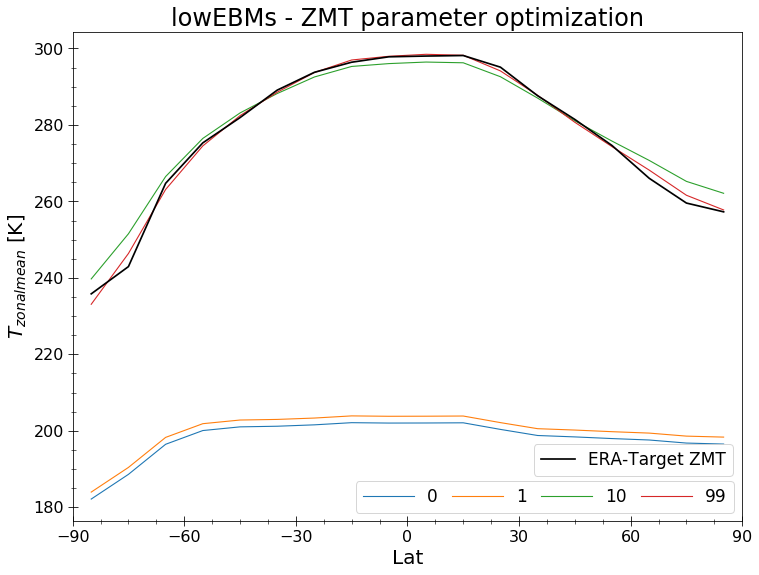

In [57]:
plt.figure(figsize=(12,9))
for i in [0,1,10,99]:
    plt.plot(Vars.Lat,data[i][0],label=i)
plt.legend(fontsize=17,ncol=4,columnspacing=0.8,handlelength=3,loc='lower right')
#plt.plot(Vars.Lat,data[7][0])
line2=plt.plot(Lat_10,ZMT_10,c='k',linewidth=1.7,label='ERA-Target ZMT')
plt.xticks(np.linspace(-90,90,7)), plt.xlim(-90,90)

plt.xlabel('Lat'),plt.ylabel('$T_{zonal mean}$ [K]')
plt.figlegend((line2),['ERA-Target ZMT'],fontsize=17,bbox_to_anchor=(0.858,0.215))
plt.title('lowEBMs - ZMT parameter optimization')
#plt.xlim(1808,1858)
plt.savefig('Data/ZMT_Optimization.eps',format='EPS',bbox_inches='tight')

In [62]:
print(data[-1][1])

[233.09009959 246.36990456 263.11344375 274.51305497 282.41968221
 288.55264889 293.70951581 296.98019182 297.95165858 298.47074786
 298.21671032 294.12617231 287.73587446 280.69268811 274.31756221
 268.17909919 261.60364255 257.76262812]


ValueError: x and y must have same first dimension, but have shapes (13, 18) and (17,)

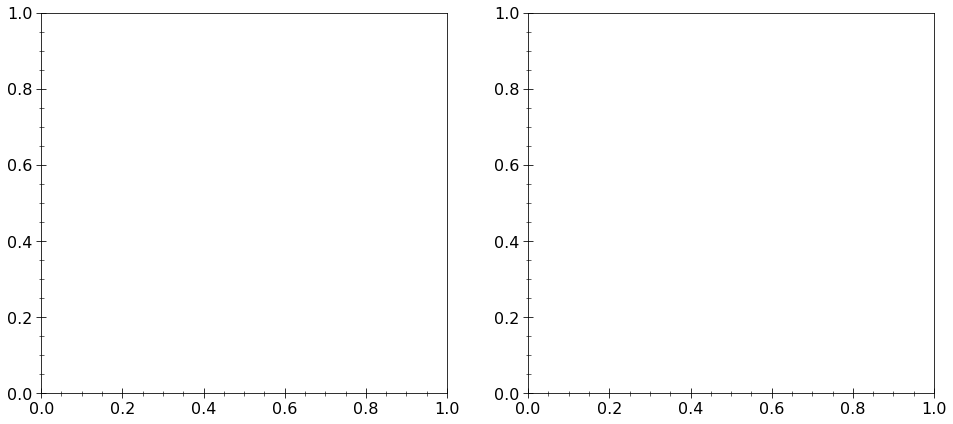

In [59]:
fig,ax=plt.subplots(1,2,figsize=(16,7))
Lat_10,ZMT_10=np.loadtxt('Data/ERA_ZMT_Mean_10deginterpolated.txt')
Lat_ERA,ZMT_ERA=np.loadtxt('Data/ERA_ZMT_Mean.txt')
#plt.plot(Vars.Lat,data[1][-1]+elevation)
#plt.plot(Lat_10,ZMT_10)
for i in [0,1,10,99]:
    ax[0].plot(np.arange,data-data,label='Optimized_GMT')
    ax[0].legend(loc='lower right')

ax[1].plot(Vars.Lat,data[1][0]+elevation,label='ZMT Optimized_GMT')
ax[1].plot(Lat_10,ZMT_10,label='Expected ZMT')
ax[1].legend(loc='lower right')
#plt.savefig('GMT_Optimization_Comparison.eps',format='EPS',bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


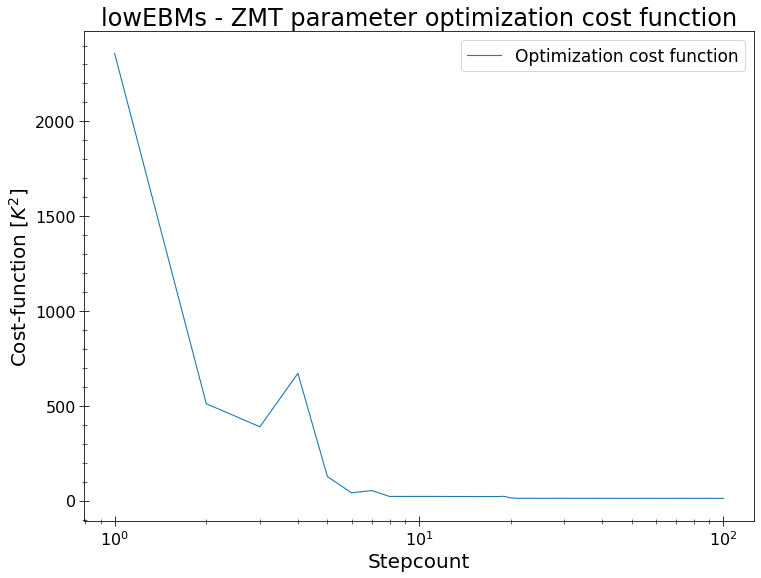

In [55]:
plt.figure(figsize=(12,9))
plt.plot(np.arange(100)+1,F[:,0],label='Optimization cost function')
#plt.yscale('log')
plt.xscale('log')
plt.xlabel('Stepcount'),plt.ylabel('Cost-function [$K^2$]')
#plt.figlegend((line2),['ERA-Target ZMT'],fontsize=17,bbox_to_anchor=(0.858,0.215))
plt.legend(fontsize=17)
plt.title('lowEBMs - ZMT parameter optimization cost function')
#plt.xlim(1808,1858)
plt.savefig('Data/ZMT_Optimization_CostFunc.eps',format='EPS',bbox_inches='tight')

In [14]:
#setup={'number_of_parameters': len(P0), 'number_of_cycles': 1, 'number_of_parallels': len(P0)*2+1}
config_base=importer('Dev_Data/Optimization/Sellers.ini')
variable_importer(config_base,control=True,accuracy=1e-4)
#print(config_base)
config_base,ParasCTRL=add_sellersparameters(config_base,\
                                    parameterinterpolatorstepwise,'SellersParameterization.ini',2,0,True,True)
elevation=-0.0065*np.array(ParasCTRL[1][1])
#P_config=reshape_parameters(P0,P_pert)
labels=[['func1','m'],['func1','gamma'],['func2','factor_oc'],['func2','factor_kwv'],['func2','factor_kair']]
P_optimal=[0.4668,2.4762e-15,1.1689,1.16658,1.1942]
config=add_parameters(config_base,P_optimal,labels)
#print(config)
data=rk4alg(model_equation,config['eqparam'],config['rk4input'],config['funccomp'],progressbar=True)

Loading Configuration from: Dev_Data/Optimization/Sellers.ini
Starting controlrun with a temperature accuracy of 0.0001 K on the GMT over 1000 datapoints.
Loading Parameters from: /Home/siv32/bsc029/.local/lib/python3.6/site-packages/lowEBMs/Tutorials/Config/Data/SellersParameterization.ini


Steady State reached after 29943 steps, within 41.05894374847412 seconds
Finished controlrun over 1982.035616438356 years. Runtime: 41.0869026184082 s


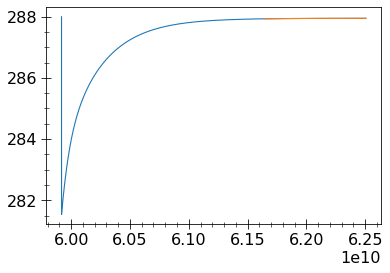

In [9]:
plt.plot(data[0],data[2])
plt.plot(data[0][-10000:],data[2][-10000:])

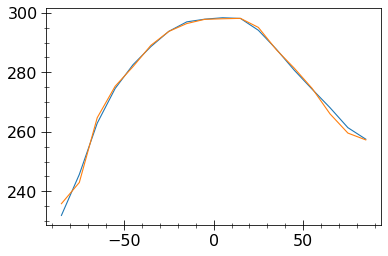

In [15]:
plt.plot(Vars.Lat,data[1][-1]+elevation)
plt.plot(Lat_10,ZMT_10)